In [2]:
import sys
print(sys.executable)


c:\Users\akash\OneDrive\Desktop\fake_news_classifier\venv\Scripts\python.exe


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report


In [4]:
# Set plot Options
plt.rcParams['figure.figsize'] = (12,8)
default_plot_color = "#00bfbf"

In [5]:
data = pd.read_csv('fake_news_data.csv')
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Counts of Article Classification')

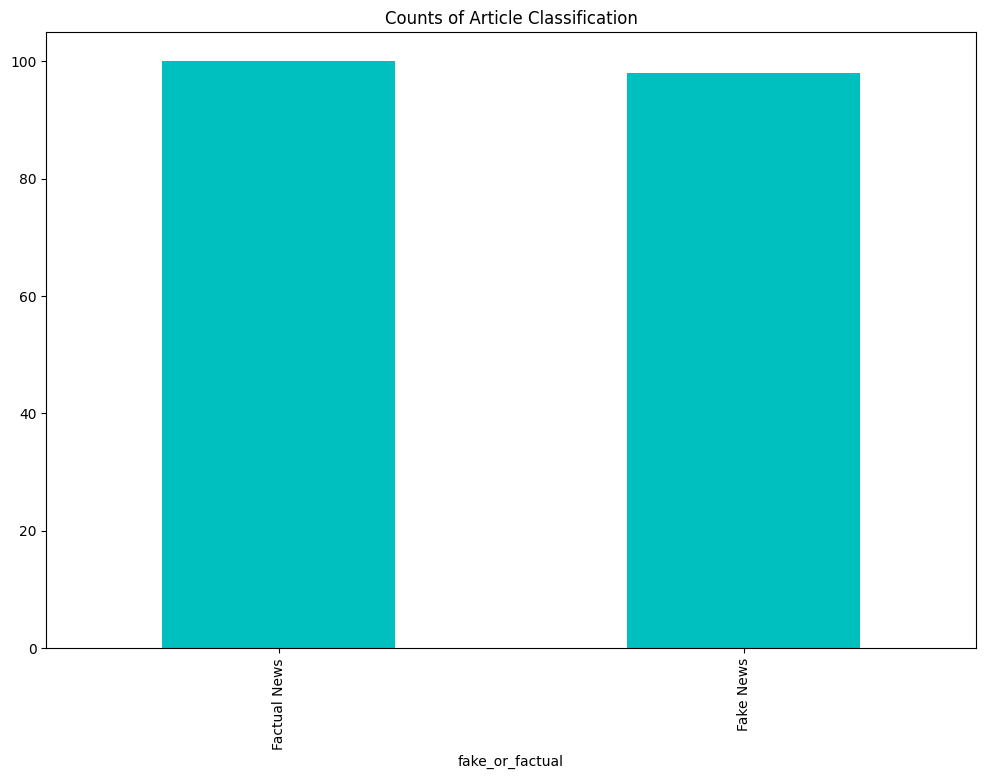

In [7]:
data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_color)
plt.title('Counts of Article Classification')

## POS Tagging

In [8]:
nlp = spacy.load('en_core_web_sm')

In [9]:
fake_news = data[data['fake_or_factual'] == 'Fake News']
fact_news = data[data['fake_or_factual'] == 'Factual News']

In [10]:
fake_spacydocs = list(nlp.pipe(fake_news['text']))
fact_spacydocs = list(nlp.pipe(fact_news['text']))

In [11]:
import spacy.tokens


def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [12]:
fake_tagdf = []
columns = ['tokens', 'ner_tag', 'pos_tag']

In [13]:
for ix, doc in enumerate(fake_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagdf.append(tags)

In [14]:
fake_tagdf = pd.concat(fake_tagdf)

In [15]:
fact_tagdf = []
for ix, doc in enumerate(fact_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagdf.append(tags)


In [16]:
fact_tagdf = pd.concat(fact_tagdf)

In [17]:
fake_tagdf.head()

,tokens,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [18]:
pos_count_fake = fake_tagdf.groupby(['tokens', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [19]:
pos_count_fake.head(10)

,tokens,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [20]:
pos_count_fact = fact_tagdf.groupby(['tokens', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_count_fact.head(10)

,tokens,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [21]:
pos_count_fake.groupby('pos_tag')['tokens'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
Name: tokens, dtype: int64

In [22]:
pos_count_fact.groupby('pos_tag')['tokens'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
Name: tokens, dtype: int64

In [23]:
pos_count_fake[pos_count_fake.pos_tag == 'NOUN'][:15]

,tokens,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [24]:
pos_count_fact[pos_count_fact.pos_tag == 'NOUN'][:15]

,tokens,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


## Named Entities

In [25]:
top_entities_fake = fake_tagdf[fake_tagdf['ner_tag'] != ''].groupby(['tokens', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
top_entities_fact = fact_tagdf[fact_tagdf['ner_tag'] != ''].groupby(['tokens', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [26]:
print(top_entities_fake['ner_tag'].unique())


['PERSON' 'ORG' 'DATE' 'GPE' 'NORP' 'CARDINAL' 'ORDINAL' 'MONEY' 'PERCENT'
 'TIME' 'WORK_OF_ART' 'FAC' 'LOC' 'LAW' 'EVENT' 'PRODUCT' 'QUANTITY']


In [27]:
ner_pallets = {
    'ORG' : sns.color_palette('Set2').as_hex()[0],
    'GPE' : sns.color_palette('Set2').as_hex()[1],
    'NORP' : sns.color_palette('Set2').as_hex()[2],
    'PERSON' : sns.color_palette('Set2').as_hex()[3],
    'DATE' : sns.color_palette('Set2').as_hex()[4],
    'CARDINAL' : sns.color_palette('Set2').as_hex()[5],
    'PERCENT' : sns.color_palette('Set2').as_hex()[6]
}

In [28]:
wanted_tags = ['ORG', 'GPE', 'NORP', 'PERSON', 'DATE', 'CARDINAL', 'PERCENT']
filtered_data = top_entities_fake[top_entities_fake['ner_tag'].isin(wanted_tags)].copy()



In [29]:
print(filtered_data['ner_tag'].unique())


['PERSON' 'ORG' 'DATE' 'GPE' 'NORP' 'CARDINAL' 'PERCENT']


[Text(0.5, 1.0, 'Most Common Named Entities in fake news ')]

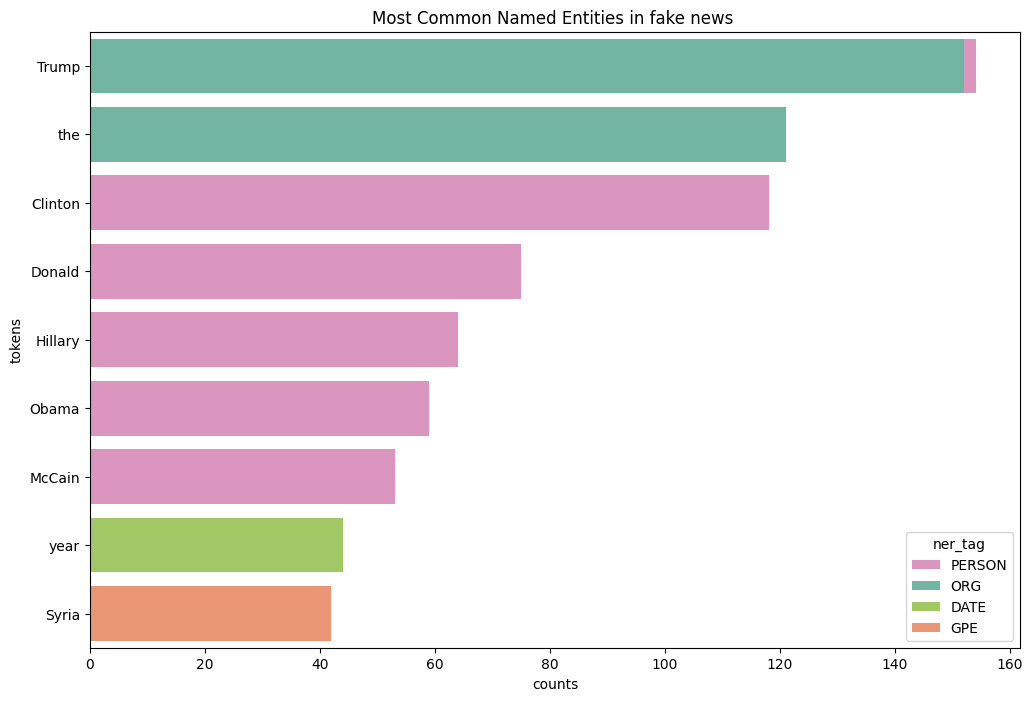

In [30]:
sns.barplot(
    x = 'counts',
    y = 'tokens',
    hue = 'ner_tag',
    palette=ner_pallets,
    data=top_entities_fake[:10],
    orient='h',
    dodge=False

).set(title='Most Common Named Entities in fake news ')

[Text(0.5, 1.0, 'Most Common Named Entities in factual news ')]

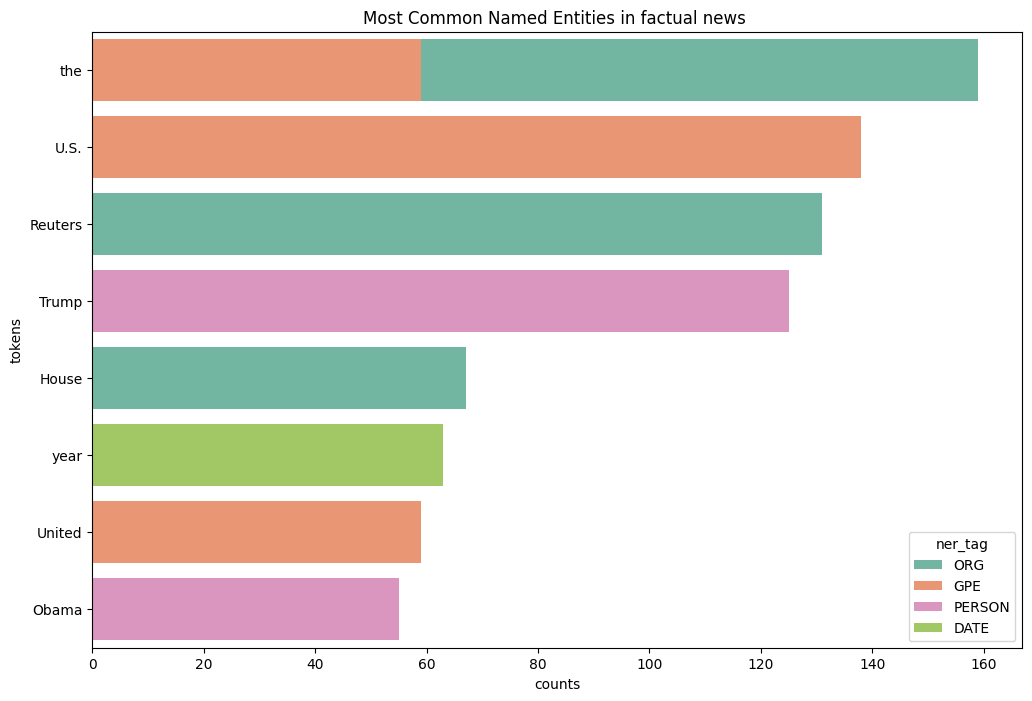

In [31]:
sns.barplot(
    x = 'counts',
    y = 'tokens',
    hue = 'ner_tag',
    palette=ner_pallets,
    data=top_entities_fact[:10],
    orient='h',
    dodge=False

).set(title='Most Common Named Entities in factual news ')

## Text Preprocessing

In [32]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [33]:
data['text_clean'] = data.apply(lambda x: re.sub(r"^[^-]*-\s", "", x['text']), axis=1)

In [34]:
data['text_clean'] = data['text_clean'].str.lower()
data['text_clean'] = data.apply(lambda x: re.sub(r"([^\w\s])", "", x['text_clean']), axis=1)

In [35]:
nltk.download('stopwords')

en_stopwords = stopwords.words('english')
print(en_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in (en_stopwords)))

In [37]:
import nltk
nltk.download('punkt', download_dir='./nltk_data')



[nltk_data] Downloading package punkt to ./nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [38]:
import nltk
from nltk.tokenize import word_tokenize
nltk.data.path.append('./nltk_data')


In [39]:
import spacy
nlp = spacy.load('en_core_web_sm')

data['text_clean'] = data['text_clean'].map(lambda text: [token.text for token in nlp(text)])


In [40]:
import nltk
nltk.download('wordnet', download_dir='nltk_data')
nltk.data.path.append('./nltk_data')




[nltk_data] Downloading package wordnet to nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [41]:
lemmatizer = WordNetLemmatizer()
data['text_clean'] = data['text_clean'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [42]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [43]:
tokens_clean = sum(data['text_clean'], [])

In [44]:
unigrams = (pd.Series(nltk.ngrams(tokens_clean,1)).value_counts()).reset_index()[:10]
print(unigrams)

           index  count
0        (said,)    580
1       (trump,)    580
2           (u,)    277
3       (state,)    275
4   (president,)    259
5       (would,)    226
6         (one,)    160
7     (clinton,)    141
8        (year,)    139
9  (republican,)    137


C:\Users\akash\AppData\Local\Temp\ipykernel_15748\341648698.py:2: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x = 'count',


[Text(0.5, 1.0, 'Most Common Unigrams after Preprocessing')]

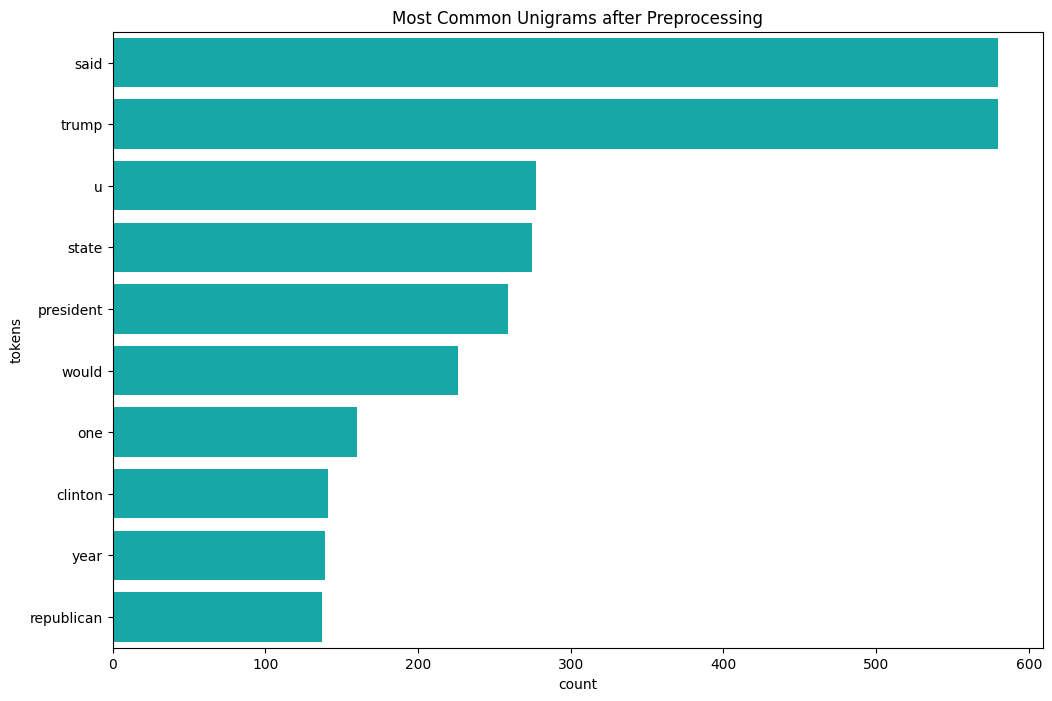

In [45]:
unigrams['tokens'] = unigrams['index'].apply(lambda x: x[0])
sns.barplot(x = 'count',
            y = 'tokens',
            data=unigrams,
            orient='h',
            palette=[default_plot_color],
            hue='tokens', legend=False)\
.set(title="Most Common Unigrams after Preprocessing")


In [46]:
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts()).reset_index()[:10]
print(bigrams)

                     index  count
0          (donald, trump)    113
1          (united, state)     84
2           (white, house)     74
3      (president, donald)     47
4       (hillary, clinton)     39
5              (new, york)     33
6         (supreme, court)     30
7             (image, via)     29
8  (trump, administration)     26
9         (official, said)     26


C:\Users\akash\AppData\Local\Temp\ipykernel_15748\657406792.py:2: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x = 'count',


[Text(0.5, 1.0, 'Most Common bigrams after preproceesing')]

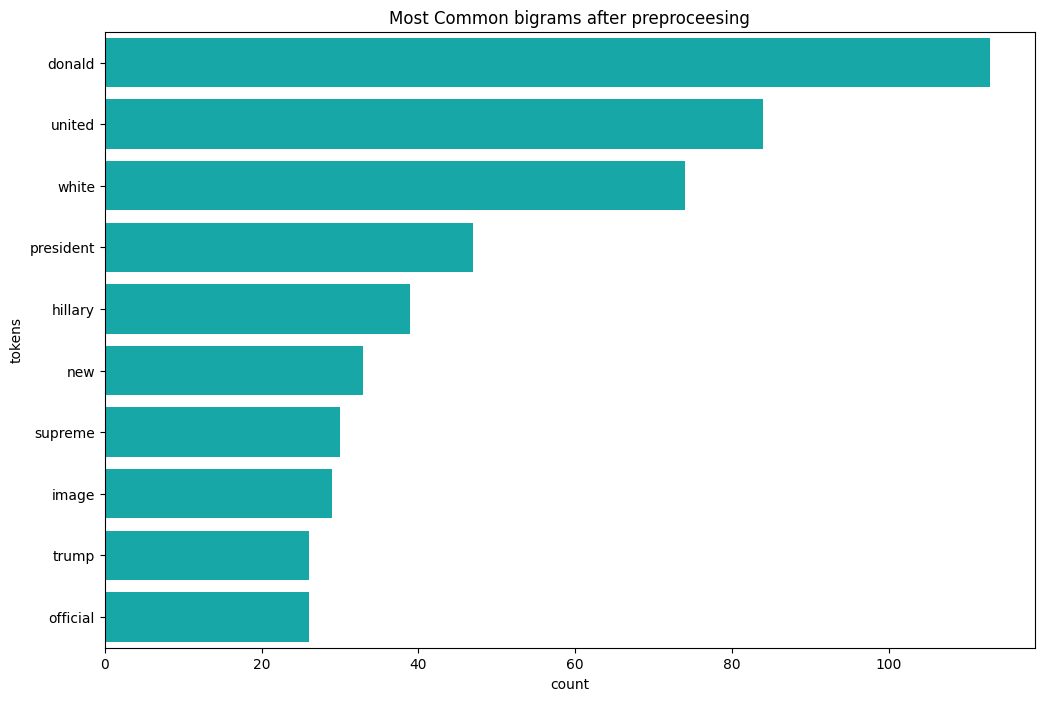

In [49]:
bigrams['tokens'] = bigrams['index'].apply(lambda x: x[0])
sns.barplot(x = 'count',
            y = 'tokens',
            data=bigrams,
            orient='h',
            palette=[default_plot_color],
            hue='tokens', legend=False)\
.set(title="Most Common bigrams after preproceesing")


## Sentiment Analysis

In [50]:
vader_sentiment = SentimentIntensityAnalyzer()

In [53]:
data['vader_Sentiment_score'] = data['text'].apply(lambda x : vader_sentiment.polarity_scores(x)['compound'])
data.head()


,title,text,date,fake_or_factual,text_clean,vader_Sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [54]:
bins = [-1, -0.1, 0.1, 1]
names =['negative', 'nuetral', 'positive']

In [55]:
data['vader_Sentiment_score'] = pd.cut(data['vader_Sentiment_score'], bins, labels=names)
data.head()

,title,text,date,fake_or_factual,text_clean,vader_Sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",positive


<Axes: xlabel='vader_Sentiment_score'>

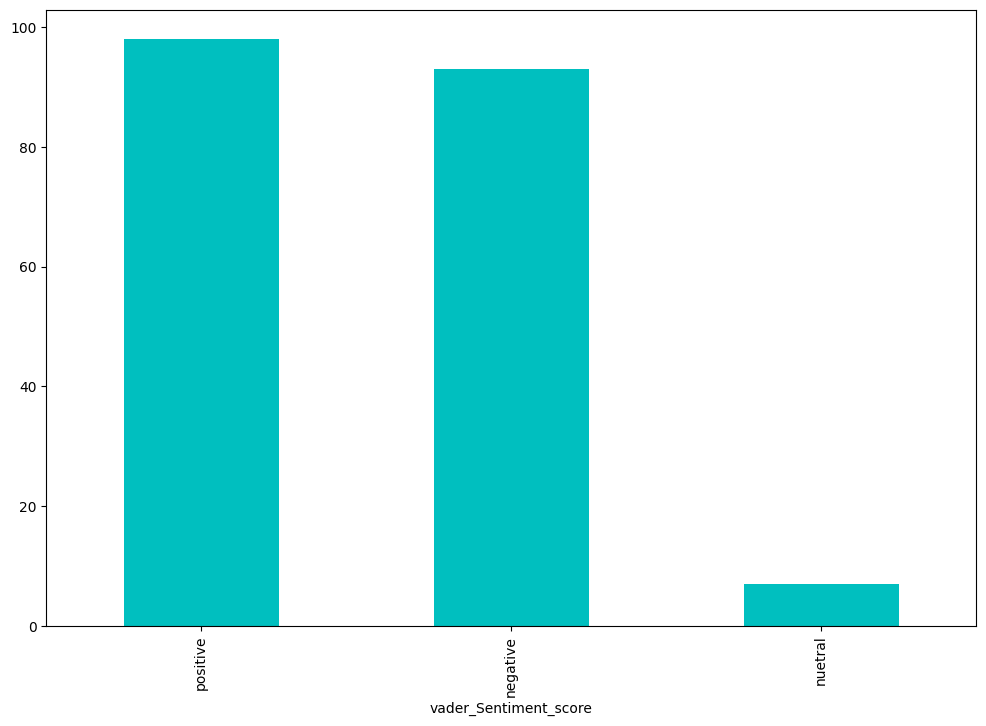

In [56]:
data['vader_Sentiment_score'].value_counts().plot.bar(color=default_plot_color)

C:\Users\akash\AppData\Local\Temp\ipykernel_15748\3672844804.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by News Type')]

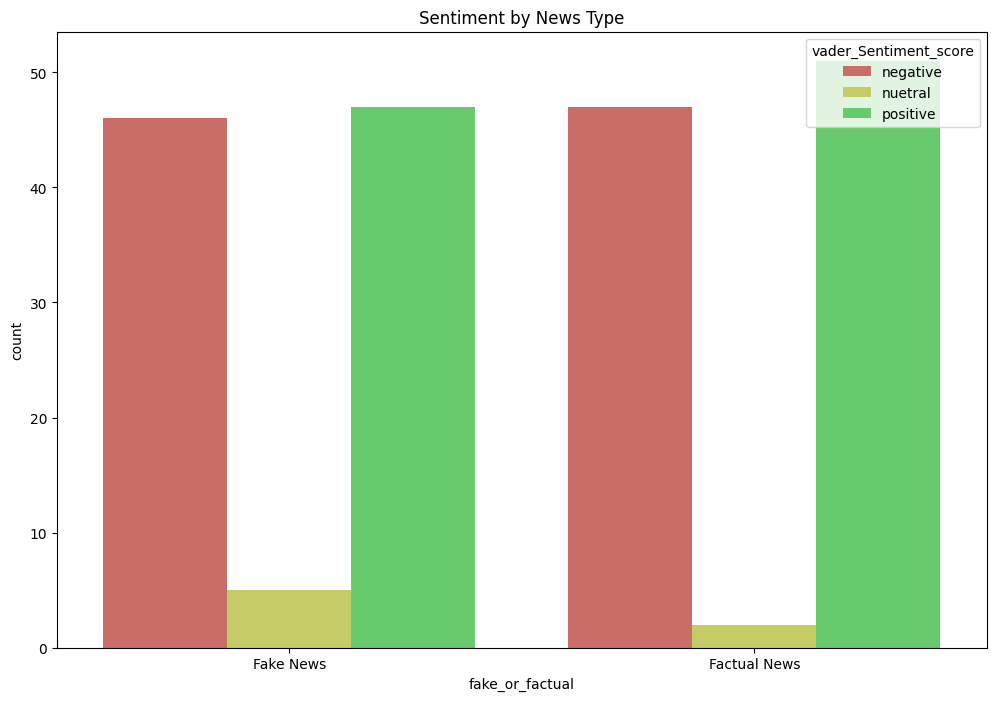

In [59]:
sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_Sentiment_score',
    palette = sns.color_palette('hls'),
    data = data


).set(title= 'Sentiment by News Type')

## Topic Modelling

In [60]:
fake_news_text = data[data['fake_or_factual']== 'Fake News']['text_clean'].reset_index(drop=True)


In [61]:
dictionary_fake = corpora.Dictionary(fake_news_text)

In [62]:
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

In [64]:
from gensim.models import CoherenceModel

cohrence_values = []
model_list = []
min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics=num_topics_i, id2word=dictionary_fake)
    model_list.append(model)
    cohrence_model = CoherenceModel(model = model, texts= fake_news_text, dictionary = dictionary_fake, coherence = 'c_v')

    cohrence_values.append(cohrence_model.get_coherence())


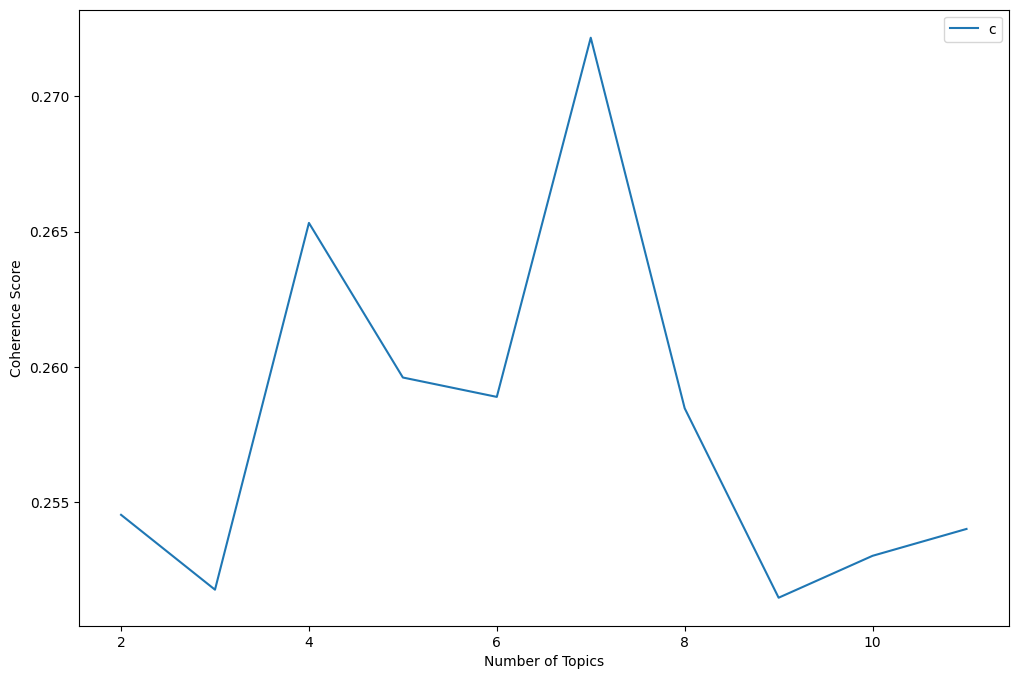

In [65]:
plt.plot(range(min_topics, max_topics + 1), cohrence_values)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend(('cohrence_values'),loc='best')
plt.show()

In [66]:
num_topics_lda = 7
lda_model = gensim.models.LdaModel(corpus=doc_term_fake, id2word=dictionary_fake, num_topics=num_topics_lda)

In [67]:
lda_model.print_topics(num_topics=num_topics_lda, num_words=10)

[(0,
  '0.012*"trump" + 0.005*"president" + 0.004*"donald" + 0.004*"u" + 0.004*"clinton" + 0.004*"year" + 0.003*"would" + 0.003*"woman" + 0.003*"one" + 0.003*"news"'),
 (1,
  '0.008*"trump" + 0.005*"u" + 0.005*"president" + 0.004*"said" + 0.004*"obama" + 0.004*"clinton" + 0.004*"state" + 0.004*"one" + 0.003*"would" + 0.003*"people"'),
 (2,
  '0.012*"trump" + 0.005*"said" + 0.005*"state" + 0.004*"president" + 0.004*"republican" + 0.004*"time" + 0.003*"one" + 0.003*"would" + 0.003*"clinton" + 0.003*"american"'),
 (3,
  '0.006*"trump" + 0.006*"clinton" + 0.005*"said" + 0.004*"state" + 0.004*"president" + 0.004*"one" + 0.004*"would" + 0.003*"woman" + 0.003*"time" + 0.003*"u"'),
 (4,
  '0.008*"trump" + 0.006*"said" + 0.004*"woman" + 0.004*"state" + 0.003*"people" + 0.003*"u" + 0.003*"obama" + 0.003*"president" + 0.003*"year" + 0.003*"time"'),
 (5,
  '0.011*"trump" + 0.005*"clinton" + 0.004*"said" + 0.004*"state" + 0.004*"obama" + 0.003*"would" + 0.003*"president" + 0.003*"hillary" + 0.003*"

In [71]:
def tfidf_corpus(doc_term_matrix):
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [72]:
def get_coherence_score(corpus, dictionary, text, min_topics, max_topics):
    coherence_values = []
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics=num_topics_i, id2word=dictionary)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    plt.plot(range(min_topics,max_topics+1), coherence_values)
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.legend(('cohrence_values'), loc='best')
    plt.show()


In [73]:
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)


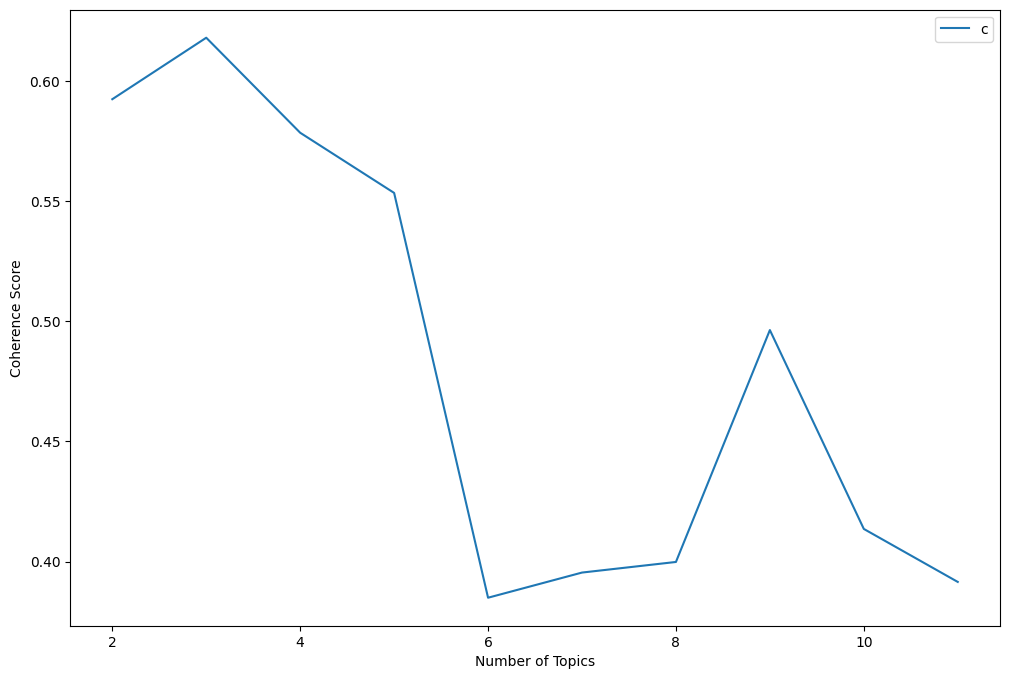

In [74]:
get_coherence_score(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [75]:
lsa_model = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=7)
lsa_model.print_topics()

[(0,
  '0.190*"trump" + 0.136*"clinton" + 0.095*"hillary" + 0.094*"obama" + 0.089*"president" + 0.087*"woman" + 0.078*"republican" + 0.078*"party" + 0.077*"flynn" + 0.074*"candidate"'),
 (1,
  '0.326*"boiler" + 0.284*"acr" + 0.244*"room" + 0.240*"pm" + 0.186*"broadcast" + 0.180*"radio" + 0.142*"animal" + 0.142*"tune" + 0.134*"jay" + 0.132*"episode"'),
 (2,
  '-0.623*"flynn" + -0.182*"immunity" + -0.122*"nana" + -0.116*"mr" + -0.110*"30" + -0.108*"march" + -0.103*"russian" + -0.100*"source" + 0.093*"school" + -0.092*"adviser"'),
 (3,
  '0.217*"clinton" + -0.186*"school" + -0.176*"student" + 0.142*"hillary" + -0.121*"county" + -0.118*"flynn" + 0.110*"sander" + 0.097*"debate" + 0.097*"woman" + 0.092*"nominee"'),
 (4,
  '0.200*"email" + -0.194*"trump" + 0.168*"dnc" + -0.142*"flynn" + 0.126*"clinton" + -0.112*"cruz" + 0.111*"department" + 0.110*"rich" + 0.102*"wikileaks" + 0.099*"sander"'),
 (5,
  '-0.277*"student" + -0.165*"conference" + -0.160*"school" + -0.138*"trump" + 0.123*"obama" + 0